In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

# Load data

In [2]:
data = pd.read_excel('./Table S2.xlsx')
cols5 = ['qtype','Al', 'Ti', 'Li','Ge', 'Sr']
for ele in cols5[1:]:
    data[ele] = pd.to_numeric(data[ele], errors='coerce')
df5 = data.loc[: , cols5].dropna()
print(len(df5))    # number of samples
df5.qtype.value_counts() # number of samples in each class

2174


orogenic      415
IRG           414
porphyry      356
greisen       326
granite       241
skarn         203
carlin        127
pegmatite      66
epithermal     26
Name: qtype, dtype: int64

In [3]:
X = df5.drop('qtype', axis=1).astype(float)
y = df5['qtype']

In [4]:
# split the data set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

# samples in testset for each class
y_test.value_counts()

IRG           86
orogenic      83
porphyry      71
greisen       63
skarn         48
granite       46
carlin        20
pegmatite     13
epithermal     5
Name: qtype, dtype: int64

# Make Pipeline

In [5]:
log_transformer = FunctionTransformer(np.log, validate=True)
pipe_clf = make_pipeline(log_transformer, StandardScaler(), SVC())
pipe_clf

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<ufunc 'log'>, validate=True)),
                ('standardscaler', StandardScaler()), ('svc', SVC())])

# Parameter estimation using grid search with cross-validation


In [6]:
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [7]:
C_range = np.logspace(-2, 8, 16 , base=2)
gamma_range = np.logspace(-5, 3, 16, base=2)

param_grid = {'svc__kernel': ['rbf'], 'svc__gamma': gamma_range,
                     'svc__C': C_range}                   
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=2)


In [8]:
grid = GridSearchCV(pipe_clf, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'svc__C': 4.0, 'svc__gamma': 1.259921049894873, 'svc__kernel': 'rbf'} with a score of 0.75


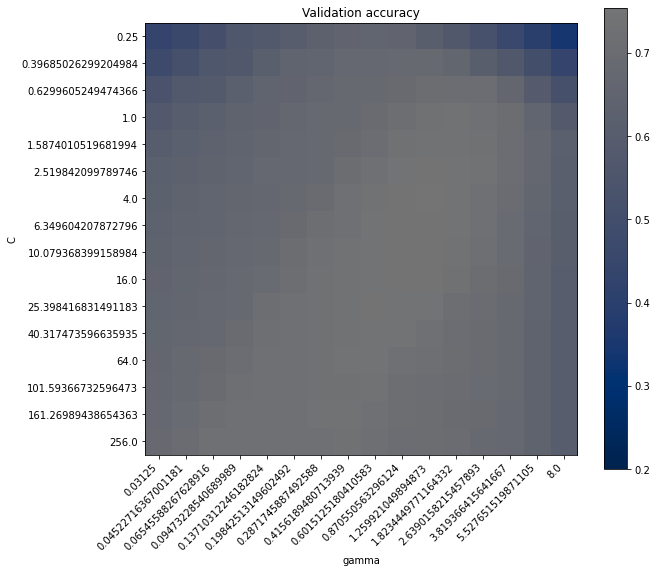

In [9]:
# Visualization

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))
plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.cividis,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.8))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45, ha='right')
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

# Model retrain


In [10]:
log_transformer = FunctionTransformer(np.log, validate=True)
pipe_clf = make_pipeline(log_transformer, StandardScaler(),
                         SVC(C=grid.best_params_['svc__C'], kernel='rbf', probability = True,
                             gamma=grid.best_params_['svc__gamma'], cache_size=1000))

In [11]:
pipe_clf.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<ufunc 'log'>, validate=True)),
                ('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=4.0, cache_size=1000, gamma=1.259921049894873,
                     probability=True))])

In [12]:
y_pred = pipe_clf.predict(X_test)
pred_train = pipe_clf.predict(X_train)
probility = pipe_clf.predict_proba(X_test)
y_pred2 = y_pred.reshape((y_pred.shape[0],1))


In [13]:
res = np.concatenate([y_pred2, probility], axis=1)
res = pd.DataFrame(res, columns= ['pred_qtype','IRG', 'carlin','epithermal', 'granite', 'greisen', 'orogenic', 'pegmatite', 'porphyry', 'skarn'])
np.sum(res.iloc[4, 1:])

1.0000000000000007

In [14]:
# train set report
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

         IRG       0.81      0.96      0.88       328
      carlin       0.96      0.99      0.98       107
  epithermal       1.00      0.90      0.95        21
     granite       0.87      0.92      0.90       195
     greisen       0.87      0.86      0.87       263
    orogenic       0.86      0.77      0.81       332
   pegmatite       0.83      0.55      0.66        53
    porphyry       0.93      0.92      0.92       285
       skarn       0.88      0.79      0.84       155

    accuracy                           0.87      1739
   macro avg       0.89      0.85      0.87      1739
weighted avg       0.87      0.87      0.87      1739



In [15]:
# final evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         IRG       0.82      0.95      0.88        86
      carlin       0.91      1.00      0.95        20
  epithermal       1.00      1.00      1.00         5
     granite       0.91      0.93      0.92        46
     greisen       0.79      0.87      0.83        63
    orogenic       0.69      0.61      0.65        83
   pegmatite       0.67      0.15      0.25        13
    porphyry       0.88      0.89      0.88        71
       skarn       0.76      0.67      0.71        48

    accuracy                           0.81       435
   macro avg       0.82      0.79      0.79       435
weighted avg       0.80      0.81      0.80       435

[[82  0  0  0  0  3  0  1  0]
 [ 0 20  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0]
 [ 0  0  0 43  1  0  1  0  1]
 [ 0  0  0  1 55  4  0  3  0]
 [13  2  0  0  7 51  0  2  8]
 [ 3  0  0  2  3  0  2  3  0]
 [ 0  0  0  1  2  4  0 63  1]
 [ 2  0  0  0  2 12  0  0 32]]


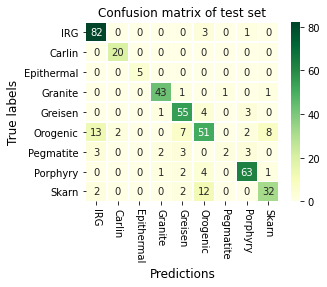

In [16]:
# heatmap the confusion matrix of test data
#---------------------------------------------------------------------
label_order = ['IRG', 'carlin','epithermal', 'granite', 'greisen', 'orogenic', 'pegmatite', 'porphyry', 'skarn']
for i in range(len(label_order)):
    if label_order[i] == 'IRG':
        pass
    else:
        label_order[i] = label_order[i].capitalize()
#-------------------------------------------------------------------
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  columns=label_order, index=label_order)

f, ax = plt.subplots(figsize=(4.75, 4.1))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, ax=ax, cmap='YlGn')
ax.set_title('Confusion matrix of test set', fontsize=12)
ax.set_xlabel('Predictions', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)

plt.xticks(rotation=270)
plt.tight_layout()
# f.suptitle('Fig. 5', x=0.05)
# f.savefig('./figures/confusion_matrix.png', dpi=300)
# f.savefig('./figures/confusion_matrix.pdf', dpi=150)

# Model persistence

In [17]:
from joblib import dump, load
dump(pipe_clf, 'quartz_clf.joblib') 

['quartz_clf.joblib']